# Figures from OHBM 2020 presentation

For any slide with an * at the top right, the code to generate the multilayer network on that slide is below. See [this page](https://www.aesizemore.com/data-visualization.html) for the original presentation.

In [1]:
## Import packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import multinetx as mx
import scipy.io as sio
import pandas as pd
import os
import sys
import mx_viz

print("Done importing packages :)")

finished defining functions
Done importing packages :)


## Two aspects, two layers (slide 14)

Aspect L1: nodes as usual
Aspect L2: "A" or "B"

In [2]:
# Set filenames
filename_json = "data/mx_2layers2.json"
filename_html = "slide14.html"

# Define number of nodes (number of nodes in largest layer)
nNodes = 10

# Define number of levels
nLayers = 2

# Use multinetx to generate two graphs each on nNodes nodes
g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=216)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=130)

# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*3,nNodes*3)))
adj_block[0:  nNodes,  nNodes:2*nNodes] = np.identity(nNodes)    # L_12
adj_block += adj_block.T

# Create multilayer graph with mx
mg = mx.MultilayerGraph(list_of_layers=[g1,g2],
                        inter_adjacency_matrix=adj_block)

# Here we can set the edge weights to different values just so we can see which are inter- and intra-layer edges
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)


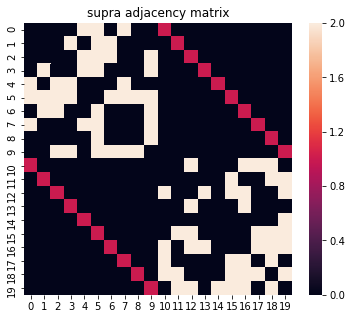

In [3]:
## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');


In [4]:
# Write to json file

# We'll use networkx positioning to get nice layouts. We create a layout using a layer that contains all nNodes nodes.
# In this case both layers are the same size so it doesn't matter :)

# Feel free to change the layout used here. It will be reflected in the d3 plot. However pos is changed, it should
# remain a dictionary mapping nodes to coordinate arrays with at least an x and y position.
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3, k=2)

G2 = mx_viz.write_mx_to_json(filename_json,mg, nNodes, pos, nLayers)
mx_viz.visualize(G2,theme="dark",path_html=filename_html);


done writing mx to data/mx_2layers2.json
Wrote visualization to: slide14.html


## Two aspects, five layers (slide 23)


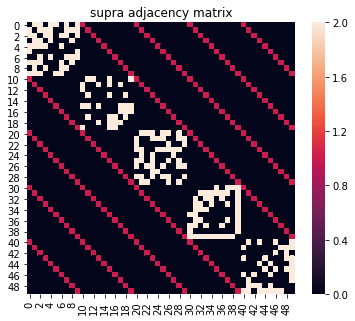

In [5]:
# Set filename
filename_json = "data/mx_5layers.json"
filename_html = "slide23.html"

# Define number of nodes (number of nodes in largest layer)
nNodes = 10

# Define number of levels
nLayers = 5

# Use multinetx to generate two graphs each on nNodes nodes
g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=218)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=132)
g3 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=192)
g4 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=19)
g5 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=102)

# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3,g4,g5],
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');



In [6]:
# Write to json file

# We'll use networkx positioning to get nice layouts. We create a layout using a layer that contains all nNodes nodes.
# In this case both layers are the same size so it doesn't matter :)
# Feel free to change the layout used here. It will be reflected in the d3 plot.
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3)

# write to json file and plot
G2 = mx_viz.write_mx_to_json(filename_json,mg, nNodes, pos, nLayers)
mx_viz.visualize(G2,theme="dark",path_html=filename_html);


done writing mx to data/mx_5layers.json
Wrote visualization to: slide23.html


## Time series (slide 25)

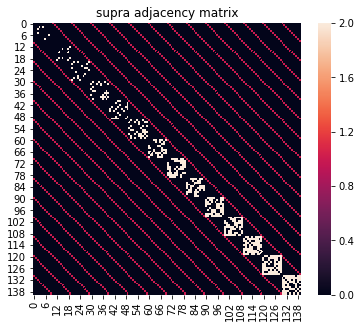

In [7]:
# Set filename
filename_json = "data/mx_timeseries.json"
filename_html = "slide25.html"

# Define number of nodes (number of nodes in largest layer)
nNodes = 10

# Define number of levels
nLayers = 14

# Use multinetx to generate fourteen graphs each on nNodes nodes
graph_layers = [mx.generators.erdos_renyi_graph(nNodes,((i+3)/(nLayers+5)),seed=np.random.randint(1,300)) for i in np.arange(nLayers)]


# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=graph_layers,
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');

In [8]:
# Write to json file

# We'll use networkx positioning to get nice layouts. We create a layout using a layer that contains all nNodes nodes.
# In this case both layers are the same size so it doesn't matter :)
# Feel free to change the layout used here. It will be reflected in the d3 plot.
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3)

# write to json file
# write_mx_to_json(filename, mx, nNodes, pos, nLayers)


G2 = mx_viz.write_mx_to_json(filename_json,mg, nNodes, pos, nLayers)
mx_viz.visualize_timeseries(G2, path_html=filename_html);

done writing mx to data/mx_timeseries.json
Wrote visualization to: slide25.html


## Non-identity inter-layer connections (slide 28)

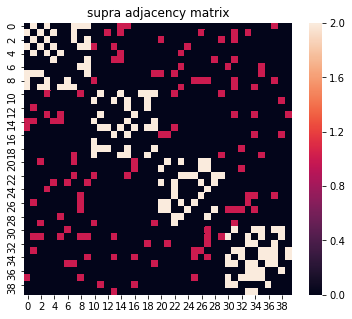

In [9]:
# Set filename
filename_json = "data/mx_nonidentity.json"
filename_html = "slide28.html"

# Define number of nodes (number of nodes in largest layer)
nNodes = 10

# Define number of levels
nLayers = 4

# Use multinetx to generate graphs each on nNodes nodes
graph_layers = [mx.generators.erdos_renyi_graph(nNodes,0.5,seed=np.random.randint(1,300)) for i in np.arange(nLayers)]


# Define adjacency between layers. Now we randomly connect nodes in separate layers.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.random.choice([0,1],size=(nNodes,nNodes),replace=True,p=[0.9,0.1])   # L_1*

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=graph_layers,
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');



In [10]:
# Write to json file

# We'll use networkx positioning to get nice layouts. We create a layout using a layer that contains all nNodes nodes.
# In this case both layers are the same size so it doesn't matter :)
# Feel free to change the layout used here. It will be reflected in the d3 plot.
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3)

# write to json file and plot
G2 = mx_viz.write_mx_to_json(filename_json,mg, nNodes, pos, nLayers)
mx_viz.visualize(G2,theme="dark",path_html=filename_html);

done writing mx to data/mx_nonidentity.json
Wrote visualization to: slide28.html


## Case where nodes are not in every layer (slide 29)

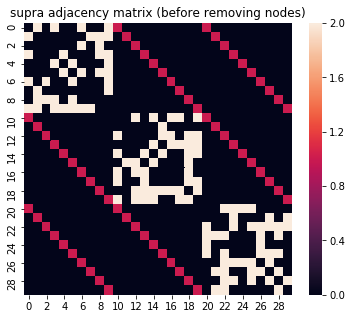

In [11]:
# When we do not have all nNodes in each layer, we will proceed as before but then delete nodes towards the end

# Set filenames
filename_json = "data/mx_missingnodes.json"
filename_html = "slide29.html"

# Define number of nodes (number of nodes in largest layer)
nNodes = 10

# Define number of levels
nLayers = 3

# Set which nodes should not exist in the final graph
nodes_to_remove = [11, 17, 21, 25, 28]

# Use multinetx to generate two graphs each on nNodes nodes
g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=102)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=54)
g3 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=194)


# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3],
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix (before removing nodes)');



In [12]:
# Since nodes don't exist in every layer, it might be easier to visualize with a circular layout...
pos = nx.circular_layout(g1)

# Write to json -- make sure to add nodes_to_remove
G2 = mx_viz.write_mx_to_json(filename_json,mg, nNodes, pos, nLayers)
mx_viz.visualize(G2,theme="dark",path_html=filename_html);

done writing mx to data/mx_missingnodes.json
Wrote visualization to: slide29.html


## Motifs example (slide 35)

In [13]:
# Set filenames
filename_json = "data/mx_motifs.json"
filename_html = "slide35.html"

# Define number of nodes (number of nodes in largest layer)
nNodes = 7

# Define number of levels
nLayers = 2

# Use multinetx to generate two graphs each on nNodes nodes
g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=218)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=132)

# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*3,nNodes*3)))
adj_block[0:  nNodes,  nNodes:2*nNodes] = np.identity(nNodes)    # L_12
adj_block += adj_block.T

# Create multilayer graph with mx
mg = mx.MultilayerGraph(list_of_layers=[g1,g2],
                        inter_adjacency_matrix=adj_block)

# Here we can set the edge weights to different values just so we can see which are inter- and intra-layer edges
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)


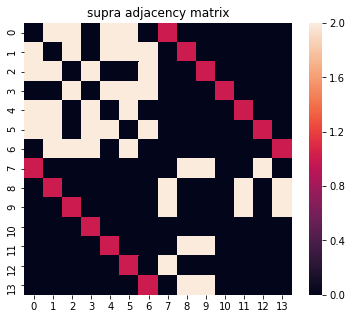

In [14]:
## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');

In [15]:
# See previous cells for descriptions
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3, k=1)

# write to json file and plot
G2 = mx_viz.write_mx_to_json(filename_json,mg, nNodes, pos, nLayers)
mx_viz.visualize(G2,theme="dark",path_html=filename_html);

done writing mx to data/mx_motifs.json
Wrote visualization to: slide35.html


## Centrality example

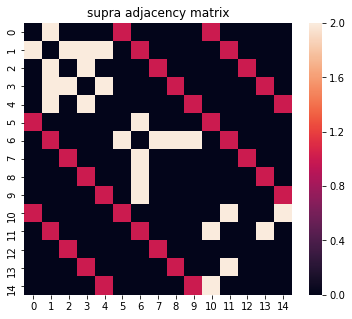

In [16]:
# Set filenames
filename_json = "data/mx_centrality.json"
filename_html = "slide36.html"

# Define number of nodes (number of nodes in largest layer)
nNodes = 5

# Define number of levels
nLayers = 3

# Use multinetx to generate two graphs each on nNodes nodes
g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=13)
g2 = mx.generators.barabasi_albert_graph(nNodes,1,seed=48)
g3 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=72)

# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3],
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');


In [17]:
# Write to json file

# See previous cells for details.
pos = nx.circular_layout(g1)

# write to json file and plot
G2 = mx_viz.write_mx_to_json(filename_json,mg, nNodes, pos, nLayers)
mx_viz.visualize(G2,theme="dark",path_html=filename_html);

done writing mx to data/mx_centrality.json
Wrote visualization to: slide36.html


## Communities example (slide 37)

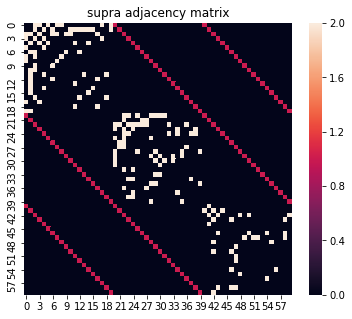

In [18]:
# Set filenames
filename_json = "data/mx_communities.json"
filename_html = "slide37.html"

# Define number of nodes (number of nodes in largest layer)
nNodes = 20

# Define number of levels
nLayers = 3

# Use multinetx to generate two graphs each on nNodes nodes
g1 = mx.generators.powerlaw_cluster_graph(nNodes,2,0.7,seed=48)
g2 = mx.generators.powerlaw_cluster_graph(nNodes,2,0.9,seed=68)
g3 = mx.generators.erdos_renyi_graph(nNodes,0.1,seed=72)


# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3],
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');


In [19]:
# Write to json file

# See previous cells for details.
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3, k=1)

# write to json file and plot
G2 = mx_viz.write_mx_to_json(filename_json,mg, nNodes, pos, nLayers)
mx_viz.visualize(G2,theme="dark",path_html=filename_html);

done writing mx to data/mx_communities.json
Wrote visualization to: slide37.html
